True Labels: [[0.00731493]
 [0.00380376]
 [0.00321857]
 [0.00312104]
 [0.00292597]]
Lower Bounds: [0.         0.00081801 0.00078092 0.00119801 0.00109473]
Mean: [ 0.00236779  0.00225947 -0.0013149   0.0535055   0.00418945]
Upper Bounds: [0.1726833  0.3210318  0.31725678 0.59643364 0.39035928]
Plot saved to quantileTestPlot_v10_100.png


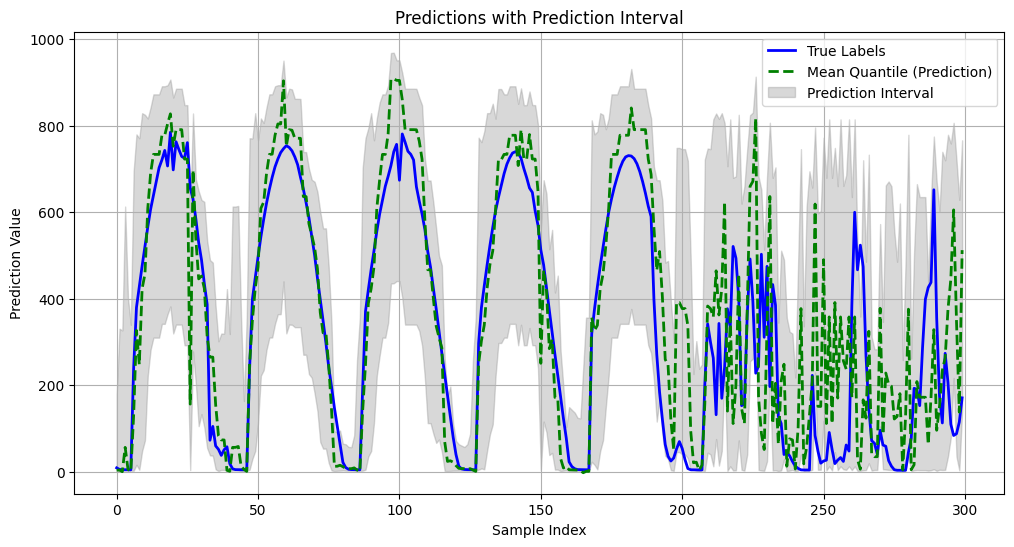

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataset import WebcamDataset
from dual_model import DualCNN_LSTM
from quantile_regression import QuantileRegressionModel
from trainer import Trainer
from plotting import plot_predictions_vs_ground_truth  # Ensure this is available if you have a plotting script.
from interval_prediction import predict_intervals  # Ensure this is the updated version that handles meteo_data.
from plotting import plot_predictions_quantile
from normalize_datasets import preprocess_and_save


In [12]:
import numpy as np

# load common_time_test.npy
common_time_test = np.load('./data/common_time_train.npy', allow_pickle=True)

normalized_train = np.load('./data/normalized_meteo_train.npy', allow_pickle=True)


# print('Shape of common_time_test:', common_time_test.shape)
# # print first 5 elements of common_time_test
# print('First 5 elements of common_time_test:', common_time_test[:100])

print('Shape of normalized_train:', normalized_train.shape)


Shape of normalized_train: (85379, 19)


In [3]:
# Normalize data
training_images_path = "./data/X_M_train.npy"
training_ghi_values_path = "./data/labels_train.npy"
validation_images_path = "./data/X_M_val.npy"
validation_ghi_values_path = "./data/labels_val.npy"
test_images_path = "./data/X_M_test.npy"
test_ghi_values_path = "./data/labels_test.npy"
train_meteo_path = "./data/meteo_data_train.csv"
val_meteo_path = "./data/meteo_data_val.csv"
test_meteo_path = "./data/meteo_data_test.csv"

output_images_path = "./output_test/normalized_X_M"
output_ghi_values_path = "./output_test/normalized_labels"


output_meteo_train_path = "./output_test/normalized_meteo_train.npy"
output_meteo_val_path = "./output_test/normalized_meteo_val.npy"
output_meteo_test_path = "./output_test/normalized_meteo_test.npy"

preprocess_and_save(
    training_images_path, training_ghi_values_path, 
    validation_images_path, validation_ghi_values_path, 
    test_images_path, test_ghi_values_path, 
    output_images_path, output_ghi_values_path, 
    batch_size=32, new_size=(224, 224), normalize_labels=False,
    train_meteo_path=train_meteo_path, 
    val_meteo_path=val_meteo_path, 
    test_meteo_path=test_meteo_path, 
    output_meteo_train_path=output_meteo_train_path,
    output_meteo_val_path=output_meteo_val_path,
    output_meteo_test_path=output_meteo_test_path
)

Shape of train_images: (13800, 250, 250, 3)
Sample image shape: (250, 250, 3)
First sample: [[[186 193 209]
  [185 192 209]
  [185 192 208]
  ...
  [185 192 209]
  [187 194 210]
  [187 194 210]]

 [[188 195 211]
  [187 194 211]
  [187 194 210]
  ...
  [188 195 212]
  [188 195 211]
  [189 196 212]]

 [[191 198 214]
  [190 196 212]
  [190 197 213]
  ...
  [189 196 212]
  [190 197 213]
  [190 197 213]]

 ...

 [[ 85  78  65]
  [ 84  77  62]
  [ 81  75  61]
  ...
  [ 89  83  69]
  [ 89  82  68]
  [ 89  82  67]]

 [[ 89  83  67]
  [ 85  78  62]
  [ 82  75  61]
  ...
  [ 88  81  67]
  [ 91  84  69]
  [ 89  81  66]]

 [[ 87  82  69]
  [ 86  80  67]
  [ 82  76  64]
  ...
  [ 88  82  70]
  [ 89  83  70]
  [ 85  77  64]]]
   AirTemp  Azimuth  CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  GtiFixedTilt  \
0     -0.3      -22          17.9          -2.9    0    0    0             0   
1     -0.3      -27          17.4          -3.0    0    0    0             0   
2     -0.3      -32          17.4     

KeyboardInterrupt: 

In [ ]:

# Chosen meteo features:
# AirTemp (1), CloudOpacity (3), PrecipitableWater (10), RelativeHumidity (11), Zenith (16)
# Based on the assumed order from the original full list:
# ["Time"(0), "AirTemp"(1), "Azimuth"(2), "CloudOpacity"(3), "DewpointTemp"(4), "Dhi"(5), 
#  "Dni"(6), "Ebh"(7), "GtiFixedTilt"(8), "GtiTracking"(9), "PrecipitableWater"(10), 
#  "RelativeHumidity"(11), "SnowWater"(12), "SurfacePressure"(13), "WindDirection10m"(14), 
#  "WindSpeed10m"(15), "Zenith"(16), "AlbedoDaily"(17)]
meteo_feature_indices = [0, 1, 9, 10, 15]

subset=None

data_dir = "./data"
prefix = "normalized_"

train_dataset = WebcamDataset(
    images_path_bc=f"{data_dir}/{prefix}X_BC_train.npy",
    images_path_m=f"{data_dir}/{prefix}X_M_train.npy",
    ghi_values_path=f"{data_dir}/{prefix}labels_train.npy",
    meteo_file_path=f"{data_dir}/{prefix}meteo_train.npy",
    meteo_features=meteo_feature_indices,
    subset=subset
)
val_dataset = WebcamDataset(
    images_path_bc=f"{data_dir}/{prefix}X_BC_val.npy",
    images_path_m=f"{data_dir}/{prefix}X_M_val.npy",
    ghi_values_path=f"{data_dir}/{prefix}labels_val.npy",
    meteo_file_path=f"{data_dir}/{prefix}meteo_val.npy",
    meteo_features=meteo_feature_indices,
    subset=subset
)
test_dataset = WebcamDataset(
    images_path_bc=f"{data_dir}/{prefix}X_BC_test.npy",
    images_path_m=f"{data_dir}/{prefix}X_M_test.npy",
    ghi_values_path=f"{data_dir}/{prefix}labels_test.npy",
    meteo_file_path=f"{data_dir}/{prefix}meteo_test.npy",
    meteo_features=meteo_feature_indices,
    subset=subset
)

[[-1.73203052         nan -1.51331219 ... -0.39972029  1.91908393
   0.96972821]
 [-1.73198995         nan -1.51331219 ... -0.50550167  1.91908393
   0.96972821]
 [-1.73194937         nan -1.51331219 ... -0.50550167  1.88876953
   0.96972821]
 ...
 [ 1.73194937         nan  1.42746733 ...  0.02340524  0.46399261
  -0.42989016]
 [ 1.73198995         nan  1.39985438 ...  0.12918662  0.49430701
  -0.42989016]
 [ 1.73203052         nan  1.37224143 ...  0.12918662  0.52462142
  -0.42989016]]
[[-1.73203052         nan -1.51331219 ... -0.39972029  1.91908393
   0.96972821]
 [-1.73198995         nan -1.51331219 ... -0.50550167  1.91908393
   0.96972821]
 [-1.73194937         nan -1.51331219 ... -0.50550167  1.88876953
   0.96972821]
 ...
 [ 1.93643844         nan  1.85546811 ... -0.29393891  0.70650783
  -0.42989016]
 [ 1.93647902         nan  1.85546811 ... -0.29393891  0.73682223
  -0.42989016]
 [ 1.93651959         nan  1.84166163 ... -0.29393891  0.76713664
  -0.42989016]]
[[-1.73203052   

In [ ]:
# Define your data directory
data_dir = "./data"

# If using normalized data, set this to True and ensure normalized files exist.
normalized = True
prefix = "normalized_" if normalized else ""

# Define chosen meteo feature indices based on previous discussion
# ["Time"(0), "AirTemp"(1), "Azimuth"(2), "CloudOpacity"(3), "DewpointTemp"(4), "Dhi"(5), 
#  "Dni"(6), "Ebh"(7), "GtiFixedTilt"(8), "GtiTracking"(9), "PrecipitableWater"(10), 
#  "RelativeHumidity"(11), "SnowWater"(12), "SurfacePressure"(13), "WindDirection10m"(14), 
#  "WindSpeed10m"(15), "Zenith"(16), "AlbedoDaily"(17)]
meteo_feature_indices = [1, 3, 10, 11, 16]  # AirTemp, CloudOpacity, PrecipitableWater, RelativeHumidity, Zenith

# Subset can be used for quick tests (e.g., 128), or None for full dataset
subset = 128


In [ ]:
train_dataset = WebcamDataset(
    images_path_bc=os.path.join(data_dir, f"{prefix}X_BC_train.npy"),
    images_path_m=os.path.join(data_dir, f"{prefix}X_M_train.npy"),
    ghi_values_path=os.path.join(data_dir, f"{prefix}labels_train.npy"),
    meteo_file_path=os.path.join(data_dir, f"{prefix}meteo_train.npy"),
    meteo_features=meteo_feature_indices,
    subset=subset
)

val_dataset = WebcamDataset(
    images_path_bc=os.path.join(data_dir, f"{prefix}X_BC_val.npy"),
    images_path_m=os.path.join(data_dir, f"{prefix}X_M_val.npy"),
    ghi_values_path=os.path.join(data_dir, f"{prefix}labels_val.npy"),
    meteo_file_path=os.path.join(data_dir, f"{prefix}meteo_val.npy"),
    meteo_features=meteo_feature_indices,
    subset=subset
)

test_dataset = WebcamDataset(
    images_path_bc=os.path.join(data_dir, f"{prefix}X_BC_test.npy"),
    images_path_m=os.path.join(data_dir, f"{prefix}X_M_test.npy"),
    ghi_values_path=os.path.join(data_dir, f"{prefix}labels_test.npy"),
    meteo_file_path=os.path.join(data_dir, f"{prefix}meteo_test.npy"),
    meteo_features=meteo_feature_indices,
    subset=subset
)

print("Train images shape:", train_dataset.images_bc.shape)
print("Train GHI shape:", train_dataset.ghi_values.shape)
print("Train meteo shape:", train_dataset.meteo_data.shape)



Train images shape: (128, 224, 224, 3)
Train GHI shape: (128,)
Train meteo shape: (128, 5)


Image BC Shape: torch.Size([3, 224, 224])
Image M Shape: torch.Size([3, 224, 224])
Meteo Shape: torch.Size([5])
GHI Value: 0.0958743765950203


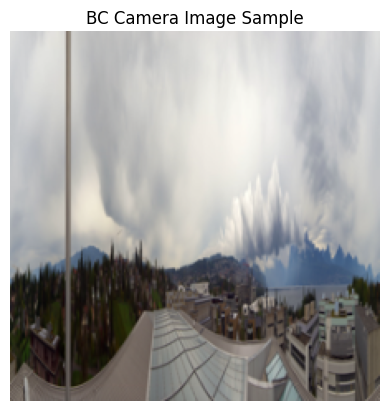

In [ ]:
(img_bc_sample, img_m_sample, meteo_sample), ghi_value = train_dataset[0]

print("Image BC Shape:", img_bc_sample.shape)
print("Image M Shape:", img_m_sample.shape)
print("Meteo Shape:", meteo_sample.shape)
print("GHI Value:", ghi_value.item())

# Show image from BC camera (just to visualize)
img_np = img_bc_sample.permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # simple min-max normalization for display
plt.imshow(img_np)
plt.title("BC Camera Image Sample")
plt.axis('off')
plt.show()

# Similarly you can check M camera image if needed


In [ ]:
num_meteo_features = len(meteo_feature_indices)  # Should be 5
model = DualCNN_LSTM(num_meteo_features=num_meteo_features)

# Wrap the model for quantile regression
model = QuantileRegressionModel(model, num_quantiles=3)
print(model)


QuantileRegressionModel(
  (base_model): DualCNN_LSTM(
    (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (meteo_fc1): Linear(in_features=5, out_features=32, bias=True)
    (meteo_fc2): Linear(in_features=32, out_features=32, bias=True)
    (meteo_dropout): Dropout(p=0.1, inplace=False)
    (lstm1): LSTM(89920, 128, batch_first=True)
    (lstm2): LSTM(128, 64, batch_first=True)
    (fc1): Linear(in_features=64, out_features=64,

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

gpu_id = 0 if torch.cuda.is_available() else "cpu"
batch_size = 32
learning_rate = 1e-3
epochs = 5  # Reduced for quick test, adjust as needed
working_dir = "./output_test"
os.makedirs(working_dir, exist_ok=True)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    gpu_id=gpu_id,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=epochs,
    working_dir=working_dir,
)


No model path provided, starting training from scratch.


In [ ]:
trainer.train()


[GPUcpu] Epoch 0 | Batchsize: 32 | Steps: 4
Epoch 0/5, Train Loss: 0.0000, Processed Train Batches: 0, Skipped Train Batches: 4, Train Time: 0.67s
Epoch 0/5, Validation Loss: 0.0000, Processed Validation Batches: 0, Skipped Validation Batches: 4, Eval Time: 0.78s
[GPUcpu] Epoch 1 | Batchsize: 32 | Steps: 4
Epoch 1/5, Train Loss: 0.0000, Processed Train Batches: 0, Skipped Train Batches: 4, Train Time: 0.20s
Epoch 1/5, Validation Loss: 0.0000, Processed Validation Batches: 0, Skipped Validation Batches: 4, Eval Time: 0.16s
[GPUcpu] Epoch 2 | Batchsize: 32 | Steps: 4
Epoch 2/5, Train Loss: 0.0000, Processed Train Batches: 0, Skipped Train Batches: 4, Train Time: 0.19s
Epoch 2/5, Validation Loss: 0.0000, Processed Validation Batches: 0, Skipped Validation Batches: 4, Eval Time: 0.14s
[GPUcpu] Epoch 3 | Batchsize: 32 | Steps: 4
Epoch 3/5, Train Loss: 0.0000, Processed Train Batches: 0, Skipped Train Batches: 4, Train Time: 0.18s
Epoch 3/5, Validation Loss: 0.0000, Processed Validation Batc

In [ ]:
val_loss, _, _ = trainer.evaluate()
print("Validation Loss:", val_loss)


Validation Loss: 0.0


In [ ]:
test_loss, _, _ = trainer.test()
print("Test Loss:", test_loss)


No valid predictions were made (all batches skipped?).
Test Loss: 0.0


In [ ]:
plot_predictions_quantile(
    true_labels_file=os.path.join(working_dir, "true_labels.npy"),
    lower_bounds_file=os.path.join(working_dir, "pred_lower_bounds.npy"),
    mean_quantiles_file=os.path.join(working_dir, "pred_mean.npy"),
    upper_bounds_file=os.path.join(working_dir, "pred_upper_bounds.npy"),
    plot_save_path=None,  # or provide a path to save the plot
    num_labels=100         # number of samples to plot, adjust as desired
)

FileNotFoundError: [Errno 2] No such file or directory: './output_test/true_labels.npy'

In [ ]:
# Example of saving a trained model snapshot:
snapshot_path = os.path.join(working_dir, "final_model.pt")
snapshot = {
    "MODEL_STATE": model.state_dict(),
    "OPTIMIZER_STATE": trainer.optimizer.state_dict(),
    "SCHEDULER_STATE": trainer.scheduler.state_dict(),
    "EPOCHS_RUN": epochs - 1
}
torch.save(snapshot, snapshot_path)
print("Model saved to:", snapshot_path)

# To load later:
# loaded_snapshot = torch.load(snapshot_path)
# model.load_state_dict(loaded_snapshot["MODEL_STATE"])
